For performance, we'll use tbb and set the `MKL_THREADING_LAYER` environment variable to `tbb` ([LensKit documentation](https://lkpy.lenskit.org/en/latest/performance.html))

Setup environment variables:

In [1]:
import sys, os

sys.path.append("../src")

os.environ['MKL_THREADING_LAYER'] = 'tbb'

Other imports:

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from tqdm.notebook import tqdm_notebook as tqdm  # progress bar
import matplotlib.pyplot as plt
import seaborn as sns
from lenskit import util

Notebook display settings:

In [3]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

# Automatically reload modules
%load_ext autoreload
%autoreload 2

tqdm.pandas()  # progress bars are useful
util.log_to_notebook()  # keep things from getting too quiet in here

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[   INFO] lenskit.util.log notebook logging configured


First, we'll load the result of our earlier data wrangling.

In [4]:
ints = pd.read_hdf('../data/processed/goodreads_interactions.h5')
books_meta = pd.read_csv('../data/processed/books_metadata.csv.gz')

[   INFO] numexpr.utils NumExpr defaulting to 6 threads.


In [5]:
ints.head()

,user,item,is_read,rating,is_reviewed
0,0,948,1,5,0
85452,201,948,1,3,0
148581,339,948,1,3,1
928107,1856,948,0,0,0
935269,1872,948,1,3,0


In [6]:
books_meta.head()

,isbn,title,url,image_url,item,author_id
0,NaN,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,740362,10333.0
1,0922915113,The Devil's Notebook,https://www.goodreads.com/book/show/287149.The...,https://images.gr-assets.com/books/1328768789m...,150331,2983296.0
2,184737297X,"Crowner Royal (Crowner John Mystery, #13)",https://www.goodreads.com/book/show/6066814-cr...,https://images.gr-assets.com/books/1328724803m...,955040,37778.0
3,NaN,The House of Memory (Pluto's Snitch #2),https://www.goodreads.com/book/show/33394837-t...,https://images.gr-assets.com/books/1493114742m...,221287,242185.0
4,0842379428,Heaven,https://www.goodreads.com/book/show/89376.Heaven,https://images.gr-assets.com/books/1406508230m...,74170,4862.0


Out dataset has five numeric columns: `user_id`, `book_id`, `is_read`, `rating`, and `is_reviewed`, which is a boolean flag indicating whether the user also left a review in addition to rating the book. According to the documentation at the [UCSD Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/shelves?authuser=0), a user rating of zero means "not provided." We'll separate ratings out for convenience here.

In [7]:
ratings = ints[ints['rating'] != 0]

We already explored the distributions of the number of ratings per user and ratings per book in the data wrangling notebook.

## Ratings distribution

We already looked at the long tail properties of the data; here, let's look at the distribution of ratings.

In [8]:
ratings.rating.value_counts().sort_index()

1      702118
2     2370388
3     9053958
4    14115501
5    12452890
Name: rating, dtype: int64

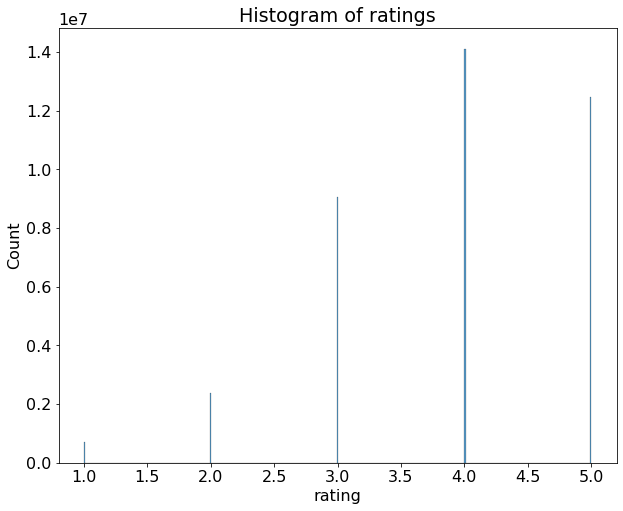

In [9]:
sns.histplot(ratings.rating)
plt.title('Histogram of ratings');

## Interactions Pipeline

You cannot rate a book without having marked it as read; similarly, you cannot review it without rating it.

In [10]:
((ints.is_read == 0) & ints.rating > 0).value_counts()

False    81961203
dtype: int64

Proportion of interactions ("shelvings") that are unread:

In [11]:
ints.is_read.astype(np.bool).value_counts(normalize=True)

True     0.514001
False    0.485999
Name: is_read, dtype: float64

Proportion of read books that are unrated:

In [12]:
(ints.is_read.astype(np.bool) & ints.rating == 0).value_counts(normalize=True)

True     0.729031
False    0.270969
dtype: float64

Proportion of rated books that are reviewed:

In [13]:
(ints.rating > 0 & ints.is_reviewed.astype(np.bool)).value_counts(normalize=True)

False    0.527888
True     0.472112
dtype: float64

## Potential Feature Engineering: Titles and Shelves for Items

Let's explore the possibility of using the *shelves* data, which consists of user-defined shelf titles, as a potential item feature. The cardinality of the shelves data is extremely high, so we'll need to reduce its dimensionality in some way. One idea is to place the shelf titles in an embedding space, potentially using a pretrained word embedding, such as GloVE. 

First, let's see the proportion of books for which we have shelf assignments.

In [14]:
shelves = pd.read_csv('../data/processed/shelves.csv.gz', index_col=None)

In [15]:
shelves.head()

,item,shelf,num
0,740362,to read,58
1,740362,fantasy,15
2,740362,fiction,6
3,740362,owned,5
4,740362,hardcover,3


In [16]:
shelves.shape

(49063413, 3)

How many books do we not have titles for?

In [17]:
n_books_no_titles = len(pd.Index(pd.unique(ints.item)).difference(pd.Index(books_meta.item)))
print('N:', n_books_no_titles, 'Proportion:', n_books_no_titles/len(pd.Index(pd.unique(ints.item))))

N: 15385 Proportion: 0.026091749342830494


How many books do we not have shelf assignments for?

In [18]:
n_books_no_shelves = len(pd.Index(pd.unique(ints.item)).difference(pd.Index(shelves.item)))
print('N:', n_books_no_shelves, 'Proportion:', n_books_no_shelves/len(pd.Index(pd.unique(ints.item))))

N: 14964 Proportion: 0.025377766471635716


## Low-signal data

The good news is that we have metadata for over 97% of books. It makes sense to drop the remaining few percent, since we don't even know what the titles of these books are, making the recommendations essentially useless.

In [19]:
print("Shape before dropping: ", ints.shape)
idx_to_drop = pd.Index(pd.unique(ints.item)).difference(pd.Index(books_meta.item))
ints = ints.set_index('item').drop(idx_to_drop).reset_index()
print("Shape after dropping missing titles: ", ints.shape)
idx_to_drop = pd.Index(pd.unique(ints.item)).difference(pd.Index(shelves.item))
ints = ints.set_index('item').drop(idx_to_drop).reset_index()
print("Shape after dropping missing shelves: ", ints.shape)

Shape before dropping:  (81961203, 5)
Shape after dropping missing titles:  (79857633, 5)
Shape after dropping missing shelves:  (79847680, 5)


In collaborative filtering models, users and items with few interactions or with an extremely high number of interactions both provide poor signal-to-noise ratios and cause computational performance issues during training for certain models. During data wrangling, we dropped users and items with fewer than 20 interactions or more than 2 standard deviations above the mean number of interactions. Let's review the current shape and sparsity structure of our data before refining this after dropping interactions with little metadata. This shouldn't reduce the size of our dataset further by too much, since we only dropped a small percentage of our interactions.

In [20]:
n_users = ints.user.unique().shape[0]
print("No. users: ", n_users)
n_items = ints.item.unique().shape[0]
print("No. items:", n_items)
print("Sparsity: ", ints.shape[0] / (n_users * n_items))

No. users:  694230
No. items: 574134
Sparsity:  0.00020032984668249762


Experience with collaborative filtering models suggests that *implicit* feedback is almost always more performant than *explicit* feedback, so we'll focus on the implicit feedback here. This means that we'll just look at the interactions and not the specific ratings, since we expect an implicit model to ultimately be the most useful.

In [21]:
user_counts = ints.groupby('user')['item'].count()
def user_keeper(count):
    return 20 < count
users_to_keep = user_counts.loc[user_counts.map(user_keeper)]
print("No. users to keep:", users_to_keep.shape[0])
print("Shape before dropping:", ints.shape)
ints = ints.merge(users_to_keep, how='inner', left_on='user', right_index=True).drop(columns=['item_y']).rename(columns={'item_x': 'item'})
print("Shape after dropping:", ints.shape)

No. users to keep: 505757
Shape before dropping: (79847680, 5)
Shape after dropping: (77898478, 5)


In [22]:
item_counts = ints.groupby('item')['user'].count()
def item_keeper(count):
    return 20 < count
items_to_keep = item_counts.loc[item_counts.map(item_keeper)]
print("No. items to keep:", items_to_keep.shape[0])
ints = ints.merge(items_to_keep, how='inner', left_on='item', right_index=True).drop(columns=['user_y']).rename(columns={'user_x': 'user'})
print("Shape after dropping:", ints.shape)

No. items to keep: 567225
Shape after dropping: (77763001, 5)


In [23]:
ints.head()
n_users = ints.user.unique().shape[0]
print("No. users: ", n_users)
n_items = ints.item.unique().shape[0]
print("No. items:", n_items)
print("Sparsity: ", ints.shape[0] / (n_users * n_items))

No. users:  505757
No. items: 567225
Sparsity:  0.0002710664363142984


## Saving results

In [24]:
ints.to_hdf('../data/processed/goodreads_interactions_post_eda.h5', key='interactions', mode='w')